# This Notebook 
- gets the data in the right format
- splits it into 
    - train the NN
    - train the [insert chosen classifier here (SVM, Random Forest, KNN, NN?)] on the NN predictions
    - test the whole network
- full testing requires cleaning more data

## Import Requirements

In [18]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from math import *
import pprint

from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping


# Import Dataset

In [31]:
#path = 'dataset'
#all_files = glob.glob(path+'/*.csv')+glob.glob(path+'/real/*.csv')
all_files = glob.glob('cleaned_data_*.csv')
df = pd.concat(pd.read_csv(f, index_col=['filename', 'frame']) for f in all_files)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [47]:
df.dropna(inplace=True)

In [32]:
cols = df.columns
cols

Index(['confidence', 'face_id', 'label', 'landmark_0', 'landmark_1',
       'landmark_10', 'landmark_11', 'landmark_12', 'landmark_13',
       'landmark_14',
       ...
       'y_61', 'y_62', 'y_63', 'y_64', 'y_65', 'y_66', 'y_67', 'y_7', 'y_8',
       'y_9'],
      dtype='object', length=207)

In [33]:
cols = pd.Index([])
cols

Index([], dtype='object')

# Split Data

In [34]:
landmark_cols = ['landmark_{}'.format(i) for i in range(68)]

In [48]:
df = df.sort_values(by=['filename', 'frame']).reset_index()

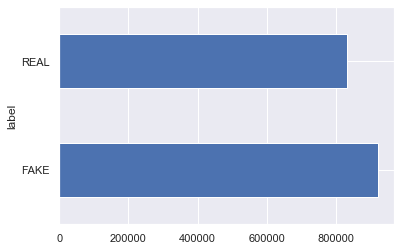

In [36]:
df.groupby(['label']).count()['filename'].plot(kind='barh')

In [49]:
# Split Files
# -- svm input 300 frames
# 40%:50%:10% -> 74.3overall, 67NN
# 20:70:10 -> 73 67NN
# -- svm input stats
# 20:70 -> 71
files = df.groupby('filename').size()
total_files = len(files)
nn_split = files.index[int(0.5*total_files)]
classifier_split = files.index[int(0.9*total_files)]


In [50]:
split_index_1 = df.loc[(df['filename']==nn_split)].head(1).index[0]
split_index_2 = df.loc[(df['filename']==classifier_split)].head(1).index[0]

In [51]:
df_mlp = df[:split_index_1]
df_mlp_predict = df[split_index_1:split_index_2:]
df_val = df[split_index_2::]

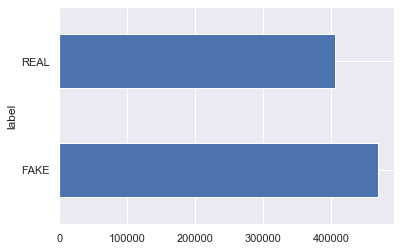

In [28]:
df_mlp.groupby(['label']).count()['filename'].plot(kind='barh')

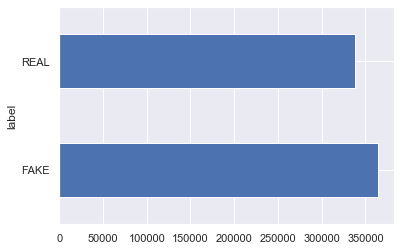

In [29]:
df_mlp_predict.groupby(['label']).count()['filename'].plot(kind='barh')

In [52]:
X_nn = df_mlp[landmark_cols].to_numpy()
X_classifier = df_mlp_predict[landmark_cols].to_numpy()
X_val = df_val[landmark_cols].to_numpy()

#convert real/fake to numbers
labels = {"REAL":0, "FAKE":1}
y_nn = df_mlp['label'].to_numpy()
y_nn=np.vectorize(labels.get)(y_nn)


y_classifier = df_mlp_predict['label'].to_numpy()
df_mlp_predict['binary_label'] = np.vectorize(labels.get)(y_classifier)
y_classifier = np.array(list(df_mlp_predict.groupby(['filename']).binary_label.max()))

y_val = df_val['label'].to_numpy()
df_val['binary_label'] = np.vectorize(labels.get)(y_val)
y_val = np.array(list(df_val.groupby(['filename']).binary_label.max()))

print(X_nn.shape, y_nn.shape)
print(X_classifier.shape, y_classifier.shape)
print(X_val.shape, y_val.shape)

(873322, 68) (873322,)
(700667, 68) (2364,)
(174710, 68) (591,)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# Create Neural Net

In [53]:
feature_vector_length = 68
num_classes = 2
input_shape = (feature_vector_length, )
print(f'Feature Shape: {input_shape}')

Feature Shape: (68,)


In [408]:
Y_train = to_categorical(y_nn, num_classes)

In [409]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

In [410]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='msle', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_nn, Y_train, epochs=15, batch_size=64, verbose=1, validation_split=0.2, callbacks=[es])

Epoch 1/15
28889/28889 [==============================] - 70s 2ms/step - loss: 0.1170 - accuracy: 0.5849 - val_loss: 0.1153 - val_accuracy: 0.5869
Epoch 2/15
28889/28889 [==============================] - 75s 3ms/step - loss: 0.1148 - accuracy: 0.5964 - val_loss: 0.1142 - val_accuracy: 0.6013
Epoch 3/15
28889/28889 [==============================] - 76s 3ms/step - loss: 0.1145 - accuracy: 0.5991 - val_loss: 0.1139 - val_accuracy: 0.6068
Epoch 4/15
28889/28889 [==============================] - 75s 3ms/step - loss: 0.1142 - accuracy: 0.6009 - val_loss: 0.1148 - val_accuracy: 0.5962
Epoch 5/15
28889/28889 [==============================] - 73s 3ms/step - loss: 0.1140 - accuracy: 0.6033 - val_loss: 0.1139 - val_accuracy: 0.6078
Epoch 6/15
28889/28889 [==============================] - 72s 2ms/step - loss: 0.1139 - accuracy: 0.6027 - val_loss: 0.1138 - val_accuracy: 0.6046
Epoch 7/15
28889/28889 [==============================] - 69s 2ms/step - loss: 0.1138 - accuracy: 0.6044 - val_loss: 0

In [411]:
model.save('model.h5')

In [54]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [55]:
predicted = model.predict(X_classifier, verbose=1)

700667/700667 [==============================] - 6s 8us/sample


In [56]:
df_mlp_predict['prediction'] = predicted[:,1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
accuracy_score(df_mlp_predict.binary_label, np.round(predicted[:,1], 0))

0.6552713343143034

In [96]:
df_fake_mean = df_mlp_predict[df_mlp_predict.label=='FAKE'].groupby(['filename']).mean()[['confidence','prediction']]
df_fake_median = df_mlp_predict[df_mlp_predict.label=='FAKE'].groupby(['filename']).median()[['confidence','prediction']]
df_fake_min = df_mlp_predict[df_mlp_predict.label=='FAKE'].groupby(['filename']).min()[['confidence','prediction']]

df_real_mean = df_mlp_predict[df_mlp_predict.label=='REAL'].groupby(['filename']).mean()[['confidence','prediction']]
df_real_median = df_mlp_predict[df_mlp_predict.label=='REAL'].groupby(['filename']).median()[['confidence','prediction']]
df_real_min = df_mlp_predict[df_mlp_predict.label=='REAL'].groupby(['filename']).min()[['confidence','prediction']]


In [142]:
q25 = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).quantile(0.25)[['prediction']].values
q75 = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).quantile(0.75)[['prediction']].values
q75-q25

array([[0.20441468],
       [0.35933933],
       [0.16394758],
       ...,
       [0.27028735],
       [0.18999472],
       [0.38192397]])

In [147]:
value = 'FAKE'
df_tmp = pd.DataFrame(df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).min())[['prediction']]
df_tmp.columns = ['min_prediction']
df_tmp['median_prediction'] = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).median()[['prediction']].values
df_tmp['mean_prediction'] = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).mean()[['prediction']].values
df_tmp['max_prediction'] = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).max()[['prediction']].values
df_tmp['std_prediction'] = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).agg(np.std, ddof=0)[['prediction']].values
df_tmp['var'] = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).agg('var')[['prediction']].values
q25 = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).quantile(0.25)[['prediction']].values
q75 = df_mlp_predict[df_mlp_predict.label==value].groupby(['filename']).quantile(0.75)[['prediction']].values
df_tmp['iqr'] = q75-q25
df_tmp['range'] = df_tmp['max_prediction'].sub(df_tmp['min_prediction'], axis = 0)

if(value=='FAKE'):
    df_fake = df_tmp
else:
    df_real = df_tmp


In [149]:
df_real.insert(0, 'label', 'REAL')
df_fake.insert(0, 'label', 'FAKE')


In [153]:
'label' in df_fake.columns

True

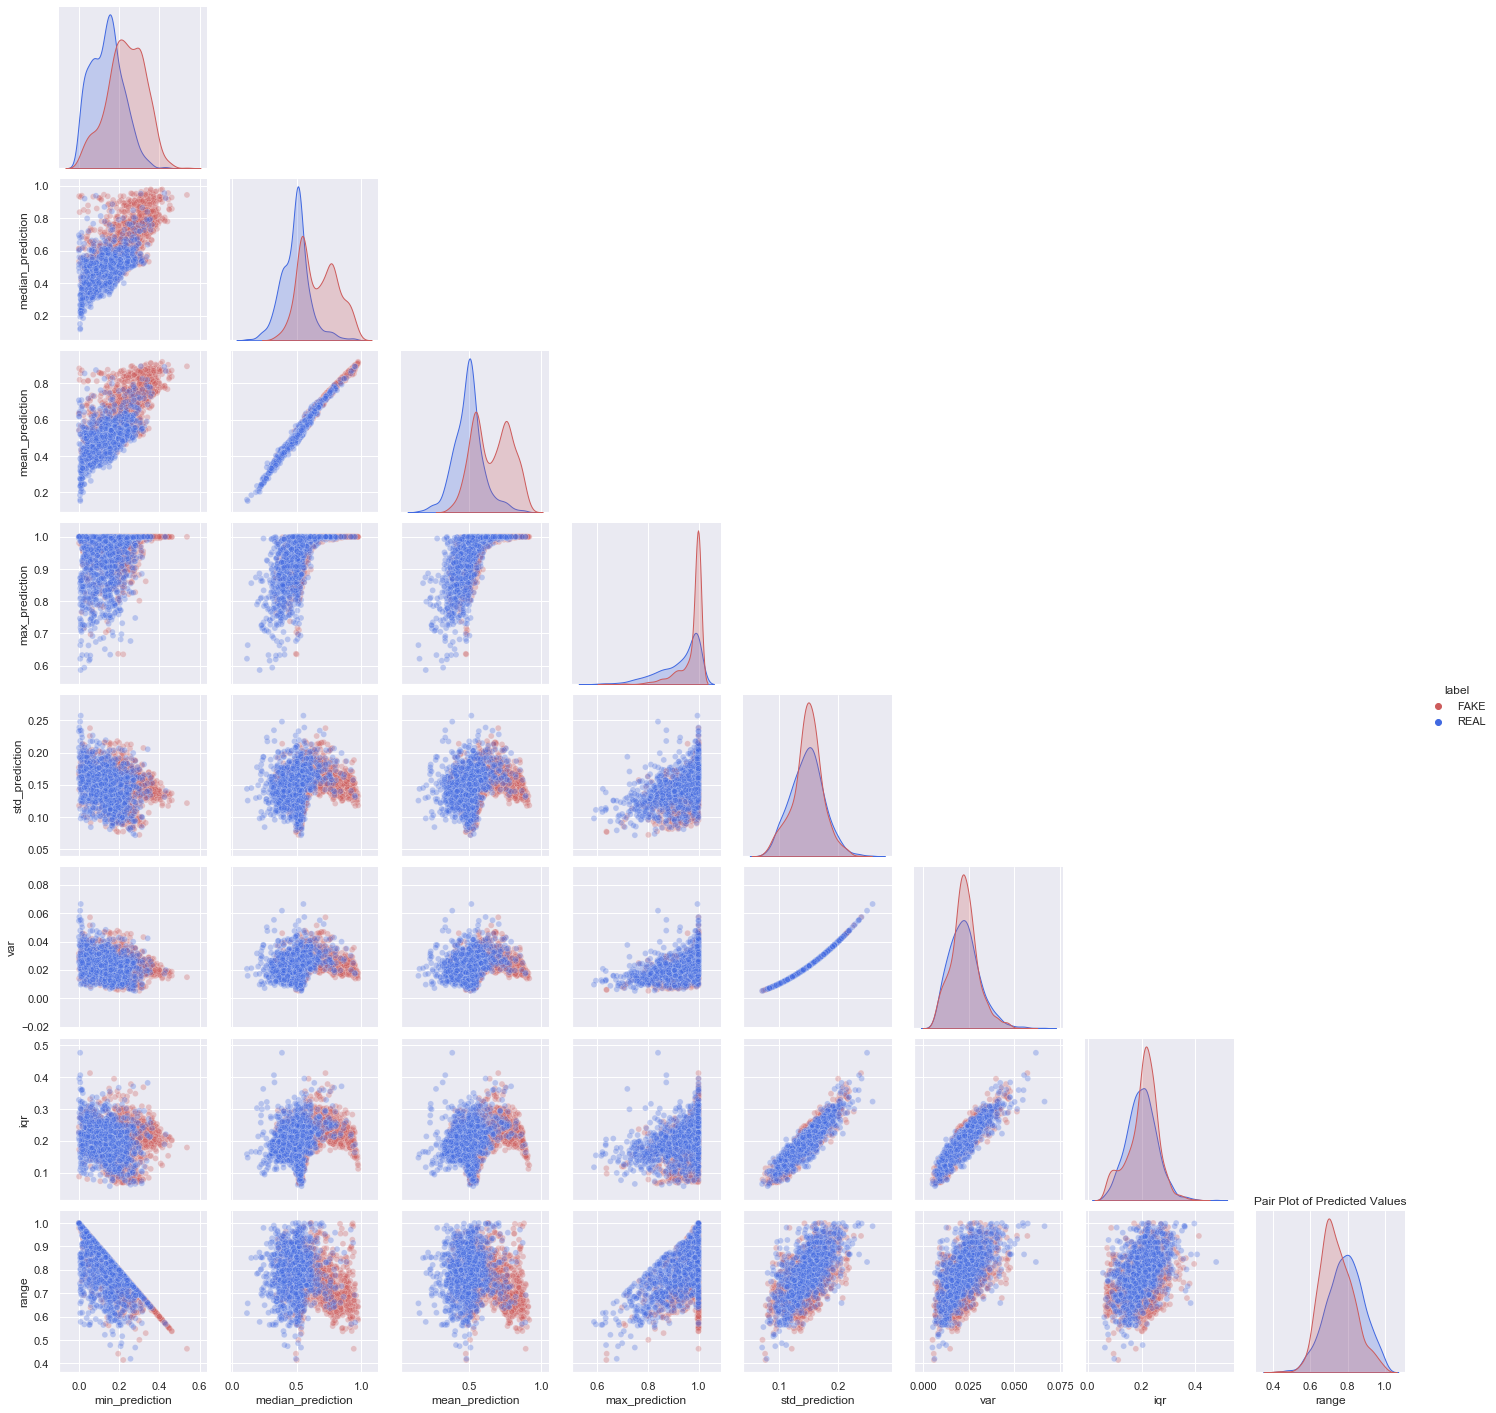

In [151]:
df_pair = pd.concat([df_fake, df_real])
ax=sns.pairplot(data=df_pair, hue='label', corner=True, palette={"REAL":"royalblue","FAKE":"indianred"}, plot_kws=dict(alpha=0.3))
#ax= sns.pairplot(data=df_fake, label='FAKE', color='indianred', alpha=0.3)
#ax1= sns.pairplot(data=df_real,label='REAL', color='royalblue', alpha=0.3)

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Pair Plot of Predicted Values')
#plt.xlabel('Frame')
#plt.ylabel('Prediction (0=Real, 1=Fake)')
plt.savefig("figures/prediction_pairplot.png", dpi=300)

Text(0, 0.5, 'Prediction (0=Real, 1=Fake)')

<Figure size 2160x1440 with 0 Axes>

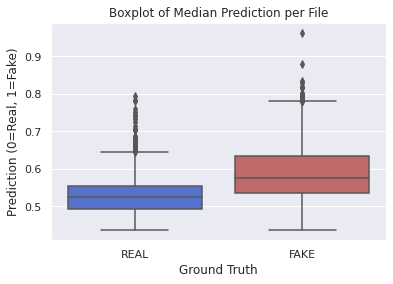

In [388]:
test = df_mlp_predict.groupby('filename').median()[['prediction','binary_label']]
plt.figure(figsize=(30,20))
fig, ax = plt.subplots()
ax= sns.boxplot(data=test, x='binary_label', y='prediction', palette={1:'indianred', 0:'royalblue'})
ax.set_xticks(range(2))
ax.set_xticklabels(['REAL', 'FAKE'])
plt.title('Boxplot of Median Prediction per File')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction (0=Real, 1=Fake)')
#plt.savefig("figures/median_boxplot_prediction_values.png", dpi=300)

<Figure size 2160x1440 with 0 Axes>

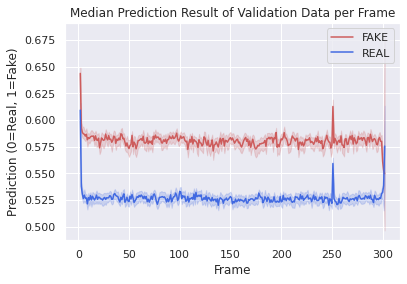

In [389]:
# y = average distance of all landmarks, x = frame
d_fake = df_mlp_predict[df_mlp_predict.label == 'FAKE'].reset_index()
d_real = df_mlp_predict[df_mlp_predict.label == 'REAL'].reset_index()

plt.figure(figsize=(30,20))
fig, ax = plt.subplots()
ax= sns.lineplot(data=d_fake, x='frame', y='prediction', label='FAKE', estimator=np.median ,markers=True, color='indianred')
ax1 = sns.lineplot(data=d_real, x='frame', y='prediction', label='REAL', estimator=np.median, color='royalblue')
plt.title('Median Prediction Result of Validation Data per Frame')
plt.xlabel('Frame')
plt.ylabel('Prediction (0=Real, 1=Fake)')
plt.savefig("figures/median_prediction_values.png", dpi=300)

<Figure size 2160x1440 with 0 Axes>

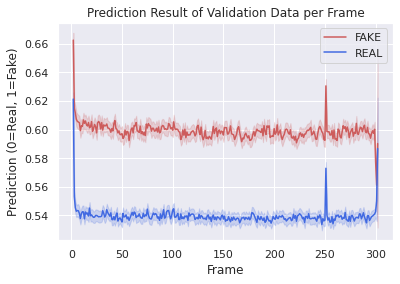

In [390]:
# y = average distance of all landmarks, x = frame
d_fake = df_mlp_predict[df_mlp_predict.label == 'FAKE'].reset_index()
d_real = df_mlp_predict[df_mlp_predict.label == 'REAL'].reset_index()

plt.figure(figsize=(30,20))
fig, ax = plt.subplots()
ax= sns.lineplot(data=d_fake, x='frame', y='prediction', label='FAKE', markers=True, color='indianred')
ax1 = sns.lineplot(data=d_real, x='frame', y='prediction', label='REAL', color='royalblue')
plt.title('Prediction Result of Validation Data per Frame')
plt.xlabel('Frame')
plt.ylabel('Prediction (0=Real, 1=Fake)')
plt.savefig("figures/prediction_values.png", dpi=300)

In [368]:
n_max = df_mlp_predict.groupby('filename').size().max()
n_max

301

In [369]:
svm_input = np.array(list(df_mlp_predict.groupby('filename').prediction.agg(list).apply(lambda x: np.pad(array=x, pad_width=(0,n_max-len(x)), mode='median'))))

In [370]:
svm_input.shape, y_svm.shape

((7780, 301), (7780,))

In [27]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(svm_input, y_svm)

SVC()

### Instead of passing all frame values as feature to SVM (or other classifier) what if instead we passed statistical features
- min
- std
- variance
- median 
- mean
- max
- range
- interquartile range
[filename: [min, std, variance, median, mean, max, range, interquartile range]
    ...
]

In [415]:
g = df_mlp_predict.groupby('filename').prediction
min_pred = g.agg('min')
max_pred = g.agg('max')
stddev_pred = g.agg('std')
var_pred = g.agg('var')
mean_pred = g.agg('mean')
median_pred = g.agg('median')
range_pred = max_pred - min_pred
q25 = g.quantile(0.25)
q75 = g.quantile(0.75)
iqr_pred = q75-q25

In [416]:
classifier_input = pd.DataFrame({
    'Min': min_pred, 
    'Max': max_pred,
    'Std' : stddev_pred,
    'Variance' : var_pred, 
    'Mean' : mean_pred, 
    'Median' : median_pred,
    'Range' : range_pred,
    'IQR' : iqr_pred
    })

In [417]:
classifier_input.to_numpy()
classifier_input.shape, y_classifier.shape

((6224, 8), (6224,))

In [418]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn import tree
#classifier = svm.SVC()
classifier = KNeighborsClassifier(n_neighbors=50)
#classifier = RandomForestClassifier()
#classifier = tree.DecisionTreeClassifier()
#classifier = NearestCentroid()
classifier.fit(classifier_input, y_classifier)

KNeighborsClassifier(n_neighbors=50)

### Validation Value
nn -> SVM

In [419]:
val_predicted = model.predict(X_val, verbose=1)

14459/14459 [==============================] - 16s 1ms/step


In [420]:
df_val['prediction'] = val_predicted[:,1]

/tmp/ipykernel_4364/309500607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['prediction'] = val_predicted[:,1]


In [30]:
df_val = df_val.reset_index()[df_val.reset_index().frame < n_max]
df_val = df_val.set_index(['filename', 'frame'])
svm_input = np.array(list(df_val.groupby('filename').prediction.agg(list).apply(lambda x: np.pad(array=x, pad_width=(0,n_max-len(x)), mode='median'))))

In [33]:
y_pred = classifier.predict(svm_input)

In [34]:
accuracy_score(y_val, y_pred)

0.7365155131264917

In [134]:
confusion_matrix(y_val, y_pred)

array([[ 309,  371],
       [ 188, 1227]])

In [299]:
# If statistical features are better:

In [421]:
g = df_val.groupby('filename').prediction
min_pred = g.agg('min')
max_pred = g.agg('max')
stddev_pred = g.agg('std')
var_pred = g.agg('var')
mean_pred = g.agg('mean')
median_pred = g.agg('median')
range_pred = max_pred - min_pred
q25 = g.quantile(0.25)
q75 = g.quantile(0.75)
iqr_pred = q75-q25

In [422]:
classifier_input = pd.DataFrame({
    'Min': min_pred, 
    'Max': max_pred,
    'Std' : stddev_pred,
    'Variance' : var_pred, 
    'Mean' : mean_pred, 
    'Median' : median_pred,
    'Range' : range_pred,
    'IQR' : iqr_pred
    })

In [423]:
classifier_input.to_numpy()
classifier_input.shape, y_val.shape

((1557, 8), (1557,))

In [424]:
y_pred = classifier.predict(classifier_input)

In [425]:
accuracy_score(y_val, y_pred)

0.6814386640976237

In [402]:
pprint.pprint(metrics.classification_report(y_val, y_pred, digits=3))


('              precision    recall  f1-score   support\n'
 '\n'
 '           0      0.618     0.676     0.646       678\n'
 '           1      0.730     0.678     0.703       879\n'
 '\n'
 '    accuracy                          0.677      1557\n'
 '   macro avg      0.674     0.677     0.674      1557\n'
 'weighted avg      0.681     0.677     0.678      1557\n')


### Results
40/50/10 Split:

| Loss Function |Accuracy     | Classifier   | Accuracy     | Precision     | Recall      | F1 Score    |
|---------------|-------------|--------------|--------------|---------------|-------------|-------------|
| MSE           | 60.4        |              |              |               |             |
|               |             |SVM           | 68.5         |62.7/73.7      |68.1/68.7    |65.3/71.1    |
|               |             | RandomForest | 68.1         |62.3/73.3      |67.7/68.4    |64.9/70.7    |
|               |             |KNN n=50      | 68.9         |63.1/74.2      |68.9/68.9    |65.9/71.5    |
| CatCrossEnt   | 60.4        |              |              |               |             |             |
|               |             | SVM          | 68.0         |61.8/74.0      |69.6/66.8    |65.5/70.2    |
|               |             | RandomForest | 68.5         |64.0/71.8      |63.1/72.6    |63.5/72.2|
|               |             | KNN          | 68.0         |63.2/72.8      |66.7/68.9    |64.4/70.8    |
| KLD           |60.4         |              |              |               |             |
|               |             | SVM          | 68.2         |62.4/73.4      |67.7/68.6    |65.0/70.9    |
|               |             | RandomForest | 68.3         |63.2/72.6      |65.5/70.5    |64.3/71.6    |
|               |             | KNN          | 68.9         |62.7/**74.9**  |**70.6**/67.6|66.4/71.1|
| CosineSimil   |  60.5       |              |              |               |             |
|               |             | SVM          | 68.4         |62.5/73.7      |68.4/68.4    |65.4/71.0    |
|               |             | RandomForest | 69.0         |64.6/72.3      |63.7/**73.0**|64.1/72.7    |      
|               |             | KNN          | 68.4         |62.8/73.3      |67.4/69.2    |65.0/71.2    |
| **MSLE**      |**60.9**     |              |              |               |             |
|               |             | SVM          | 67.8         | 62.5/72.2     |65.2/69.9    |**72.2**/69.9    |
|               |             | RandomForest | 69.7         |**65.1**/73.4  |65.8/72.8    |65.4/**73.1**      
|               |             | KNN          | **69.8**     |64.4/74.5      |68.6/70.8    |66.4/72.6






Baseline SVM
- CrossCategoricalEntropy - 
- MSE - 60.4% Acc for NN, 68.5% Acc for SVM
- Mean Squared Logarithmic Error -  
- CosineSimilarity - 
- KL - 